In [2]:
import numpy as np
import xarray as xr
import os.path as op
import xrft
import gsw
from dask.diagnostics import ProgressBar
from numpy.random import normal
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/swot/SUM03/avisoftp.cnes.fr/AVISO/pub/jason-2/gdr_d'

In [4]:
ds = xr.open_mfdataset(op.join(ddir,'JAS/ssh*.nc'))
sshJAS = ds.sshKer
sshJAS

<xarray.DataArray 'sshKer' (nALONG: 240, nDATA: 1979)>
dask.array<shape=(240, 1979), dtype=float64, chunksize=(240, 111)>
Coordinates:
  * nALONG   (nALONG) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * nDATA    (nDATA) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    lat      (nALONG, nDATA) float64 dask.array<shape=(240, 1979), chunksize=(240, 111)>
    lon      (nALONG, nDATA) float64 dask.array<shape=(240, 1979), chunksize=(240, 111)>

In [54]:
np.abs(ds.lat.diff('nALONG').mean('nDATA')).mean().values

array(0.00148902)

In [56]:
ds.lon.diff('nALONG').mean('nDATA').mean().values

array(0.04918427)

In [8]:
ds.lon.data.ravel()

dask.array<reshape, shape=(474960,), dtype=float64, chunksize=(37601,)>

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


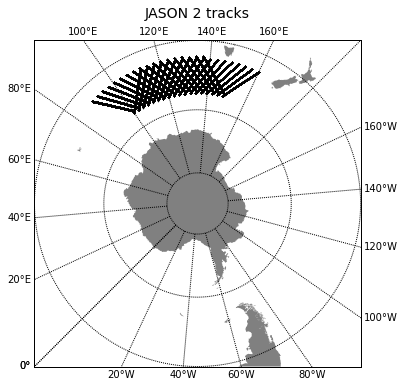

In [30]:
from mpl_toolkits.basemap import Basemap

fig= plt.figure(figsize=(6,6))
# fig.set_tight_layout(True)
ax = fig.add_subplot(111)
m = Basemap(projection='spstere',
            boundinglat=-40,
            llcrnrlon=100, urcrnrlon=150, 
#             llcrnrlat=-70, upcrnrlat=-40,
            lon_0=-45, resolution='l', ax=ax)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
m.drawparallels(np.arange(-80.,-35.,20.))
m.drawmeridians(np.arange(0.,361.,20.), labels=[1,1,1,1])
mlon, mlat = m(ds.lon.values.ravel(), ds.lat.values.ravel())
# im = m.scatter(mlon, mlat, c=ds.sshKer.data.ravel(), s=1., cmap='RdBu_r', vmax=.4, vmin=-.4)
m.scatter(mlon, mlat, c='k', s=.1, rasterized=True)
# fig.subplots_adjust(top=0.7)
# cbar_ax = fig.add_axes([0.9, 0.19, 0.018, 0.6])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r"SSH anomaly [m]", fontsize=12)
ax.set_title(r"JASON 2 tracks", fontsize=14, y=1.05)
plt.savefig(op.join(ddir,'../Figures/JASON2-SSHA_Kerguelen.pdf'))

In [158]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [159]:
nk = 140
for i in range(len(ds.nDATA)):
    #############
    da = sshJAS[:,i].values
    #############
    if len(np.ma.masked_invalid(da).compressed()) > 0:
        if np.any(np.isnan(da)):
            nans, x = nan_helper(da)
            da[nans]= np.interp(x(nans), x(~nans), da[~nans])
            ssh = xr.DataArray(da, dims=ssh.dims, coords=ssh.coords)
            tmp = xrft.dft(ssh, dim=['nALONG'], window=True, detrend='linear').compute()
#             tmp2 = (tmp*np.conj(tmp)).real
#             below45km = np.sqrt(tmp2[nk:].mean())
#             ns = normal(size=len(ds.nALONG))
#             ns *= ns.mean()**-1*below45km.values
#             tmp = xrft.dft(ssh-ns, dim=['nALONG'], window=True, detrend='linear').compute()
        if i == 0:
            sshk = xr.DataArray(np.empty_like(ds.sshKer), dims=['freq_nALONG','nDATA'],
                               coords={'freq_nALONG':tmp.freq_nALONG.data,'nDATA':ds.nDATA.data})
            sshk[:] = np.nan
            sshk[:,i] = tmp
        else:
            sshk[:,i] = tmp

eta2JAS = (sshk*np.conj(sshk)).real
eta2JAS

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/indexing.py:1147: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value


<xarray.DataArray (freq_nALONG: 240, nDATA: 1646)>
array([[3.677457e-02, 1.865649e-02, 2.491028e-01, ..., 1.440994e-01,
        2.841426e-01, 3.923133e-02],
       [9.430017e-02, 1.399104e-04, 7.831969e-02, ..., 1.339508e-01,
        1.801584e-01, 2.606385e-01],
       [2.192770e-01, 2.398811e-03, 2.793973e-02, ..., 3.329292e-02,
        6.238663e-03, 4.161180e-01],
       ...,
       [9.274327e-02, 1.149042e-03, 1.677097e-04, ..., 1.069025e-02,
        1.132807e-02, 2.234051e-02],
       [2.192770e-01, 2.398811e-03, 2.793973e-02, ..., 3.329292e-02,
        6.238663e-03, 4.161180e-01],
       [9.430017e-02, 1.399104e-04, 7.831969e-02, ..., 1.339508e-01,
        1.801584e-01, 2.606385e-01]])
Coordinates:
  * freq_nALONG  (freq_nALONG) float64 -0.5 -0.4958 -0.4917 -0.4875 -0.4833 ...
  * nDATA        (nDATA) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...

In [100]:
# dr = gsw.distance(np.array([ds.lon.mean().data-.025,ds.lon.mean().data+.025])[np.newaxis,:]*np.ones(2)[:,np.newaxis], 
#                   np.array([-45.-0.0007,-45.+0.0007])[:,np.newaxis]*np.ones(2)[np.newaxis,:], axis=0)
# dr = 2*1e3
dr = 110e3 * np.sqrt(ds.lon.diff('nALONG').mean('nDATA').mean()**2
                     * np.cos(np.pi/180.*-45.)**2
                    + np.abs(ds.lat.diff('nALONG').mean('nDATA')).mean()**2)
print(dr.values)
kr = np.fft.fftshift(np.fft.fftfreq(len(sshk.freq_nALONG), d=dr.values))
kr

3829.0795127701876


array([-1.30579686e-04, -1.29491522e-04, -1.28403358e-04, -1.27315194e-04,
       -1.26227030e-04, -1.25138866e-04, -1.24050702e-04, -1.22962538e-04,
       -1.21874373e-04, -1.20786209e-04, -1.19698045e-04, -1.18609881e-04,
       -1.17521717e-04, -1.16433553e-04, -1.15345389e-04, -1.14257225e-04,
       -1.13169061e-04, -1.12080897e-04, -1.10992733e-04, -1.09904569e-04,
       -1.08816405e-04, -1.07728241e-04, -1.06640077e-04, -1.05551913e-04,
       -1.04463749e-04, -1.03375585e-04, -1.02287421e-04, -1.01199257e-04,
       -1.00111093e-04, -9.90229285e-05, -9.79347644e-05, -9.68466004e-05,
       -9.57584363e-05, -9.46702723e-05, -9.35821082e-05, -9.24939442e-05,
       -9.14057801e-05, -9.03176161e-05, -8.92294520e-05, -8.81412880e-05,
       -8.70531239e-05, -8.59649599e-05, -8.48767958e-05, -8.37886318e-05,
       -8.27004677e-05, -8.16123037e-05, -8.05241396e-05, -7.94359756e-05,
       -7.83478115e-05, -7.72596475e-05, -7.61714834e-05, -7.50833194e-05,
       -7.39951553e-05, -

In [136]:
kr[140:]**-1*1e-3

array([45.94895415, 43.76090872, 41.7717765 , 39.95561231, 38.29079513,
       36.75916332, 35.34534935, 34.03626234, 32.82068154, 31.6889339 ,
       30.6326361 , 29.64448655, 28.71809635, 27.847851  , 27.02879656,
       26.25654523, 25.52719675, 24.83727252, 24.18366008, 23.56356623,
       22.97447708, 22.41412398, 21.88045436, 21.37160658, 20.88588825,
       20.4217574 , 19.97780615, 19.55274645, 19.14539756, 18.75467516,
       18.37958166, 18.01919771, 17.67267467, 17.33922798, 17.01813117,
       16.7087106 , 16.41034077, 16.12244005, 15.84446695, 15.57591666,
       15.31631805, 15.06523087, 14.82224328, 14.58696957, 14.35904817,
       14.13813974, 13.9239255 , 13.71610572, 13.51439828, 13.31853744,
       13.12827262, 12.94336737, 12.76359838, 12.58875456, 12.41863626,
       12.25305444, 12.09183004, 11.93479329, 11.78178312, 11.63264662,
       11.48723854, 11.34542078, 11.20706199, 11.07203715, 10.94022718,
       10.81151862, 10.68580329, 10.56297797, 10.44294413, 10.32

In [164]:
dsave = eta2JFM.to_dataset(name='JFM')
dsave.coords['kr'] = xr.DataArray(kr, dims=['freq_nALONG'], coords={'freq_nALONG':eta2JFM.freq_nALONG.data})
dsave.to_netcdf(op.join(ddir,'JASON2_45-55S_100-150E_JFMekespectra.nc'))

dsave = eta2JAS.to_dataset(name='JAS')
dsave.coords['kr'] = xr.DataArray(kr, dims=['freq_nALONG'], coords={'freq_nALONG':eta2JAS.freq_nALONG.data})
dsave.to_netcdf(op.join(ddir,'JASON2_45-55S_100-150E_JASekespectra.nc'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  after removing the cwd from sys.path.
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in reciprocal
  """


Text(0,0.5,'JAS/JFM')

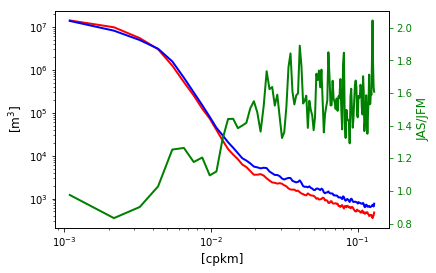

In [161]:
nk = 121
fig, ax = plt.subplots(figsize=(6,4))
ax2 = ax.twinx()
ax.plot(kr*1e3, eta2JFM.mean('nDATA')*kr**-1, 'r', lw=2)
ax.plot(kr*1e3, eta2JAS.mean('nDATA')*kr**-1, 'b', lw=2)
# im, = ax2.plot(kr[nk:]*1e3, np.cumsum((eta2JAS.mean('nDATA')*kr**-1)[nk:].data)
#                        / np.cumsum((eta2JFM.mean('nDATA')*kr**-1)[nk:].data), 'g', lw=2)
ax2.plot(kr[nk:]*1e3, (eta2JAS.mean('nDATA') / eta2JFM.mean('nDATA'))[nk:], 'g', lw=2)
ax2.yaxis.label.set_color(im.get_color())
ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"[cpkm]", fontsize=12)
ax.set_ylabel(r"[m$^3$]", fontsize=12)
# ax2.set_ylim([0.8,1.8])
ax2.tick_params(axis='y', colors=im.get_color())
ax2.set_ylabel(r"JAS/JFM", fontsize=12)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  """Entry point for launching an IPython kernel.
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  


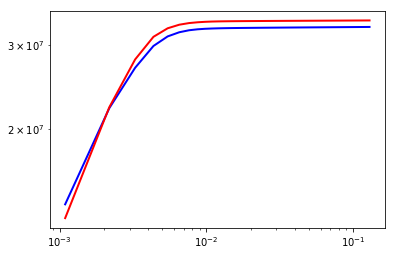

In [119]:
plt.loglog(kr[nk:]*1e3, np.cumsum((eta2JAS.mean('nDATA')*kr**-1)[nk:].data), 'b', lw=2)
plt.loglog(kr[nk:]*1e3, np.cumsum((eta2JFM.mean('nDATA')*kr**-1)[nk:].data), 'r', lw=2)